<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h2 style="text-align:center;">Pipeline de treinamento do modelo personalizado de CNN do meu TCC</h2>
</div>

<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Import das LIBS utilizadas</h2>
</div>

In [6]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from tqdm import tqdm


import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Obtendo os Dados</h2>
</div>

In [2]:
# --- Configurações de Diretórios ---
BASE_DIRECTORY = '../DATASET'
TRAIN_DIR_NAME = 'Training'
TEST_DIR_NAME = 'Testing'

# Caminhos completos para os diretórios de treino e teste
TRAIN_PATH = os.path.join(BASE_DIRECTORY, TRAIN_DIR_NAME)
TEST_PATH = os.path.join(BASE_DIRECTORY, TEST_DIR_NAME)

# --- Hiperparâmetros do Modelo e Treinamento ---
TARGET_SIZE = (224, 224) # Tamanho alvo para redimensionar as imagens
BATCH_SIZE = 32          # Número de amostras por lote
NUM_CLASSES = 4          # Número de classes de saída
RANDOM_STATE = 2025      # Seed para garantir a reprodutibilidade dos resultados


# --- Configurações de Ambiente ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo de processamento selecionado: {DEVICE.upper()}")


# --- Mapeamento de Rótulos ---
LABEL_MAP = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

# --- Inversão do Mapeamento de Rótulos ---
LABEL_MAP_INV = {v: k for k, v in LABEL_MAP.items()}

Dispositivo de processamento selecionado: CPU


In [3]:
CATEGORIES = os.listdir(TRAIN_PATH)
expected_categories = sorted(list(LABEL_MAP.keys()))
found_categories = sorted(CATEGORIES)

if expected_categories == found_categories:
    print("Consistência OK: As categorias do diretório correspondem ao LABEL_MAP.")
else:
    print("ATENÇÃO: As categorias do diretório NÃO CORRESPONDEM ao LABEL_MAP!")
    print(f"   - Esperado: {expected_categories}")
    print(f"   - Encontrado: {found_categories}")

Consistência OK: As categorias do diretório correspondem ao LABEL_MAP.


In [4]:
def display_random_images(dataset_path, num_images=2):
    dataset_name = os.path.basename(dataset_path)
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Amostra de Imagens do Dataset '{dataset_name}'", fontsize=16)

    fig, axes = plt.subplots(len(CATEGORIES), num_images, figsize=(15, 10))

    for row, category in enumerate(CATEGORIES):
        category_path = os.path.join(dataset_path, category)

        all_files = os.listdir(category_path)
        image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')) and not f.startswith('.')]

        num_available = len(image_files)
        num_to_sample = min(num_images, num_available)

        if num_to_sample > 0:
            selected_images = random.sample(image_files, num_to_sample)
        else:
            print(f"Aviso: Nenhuma imagem encontrada na pasta '{category}'.")
            continue

        for col, image_filename in enumerate(selected_images):
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(TARGET_SIZE)

            ax = axes[row, col]
            ax.imshow(image, cmap='gray')
            ax.axis('off')
            ax.set_title(category)

    plt.tight_layout(rect=[0, 0, 1, 2])
    plt.show()

<Figure size 1500x1000 with 0 Axes>

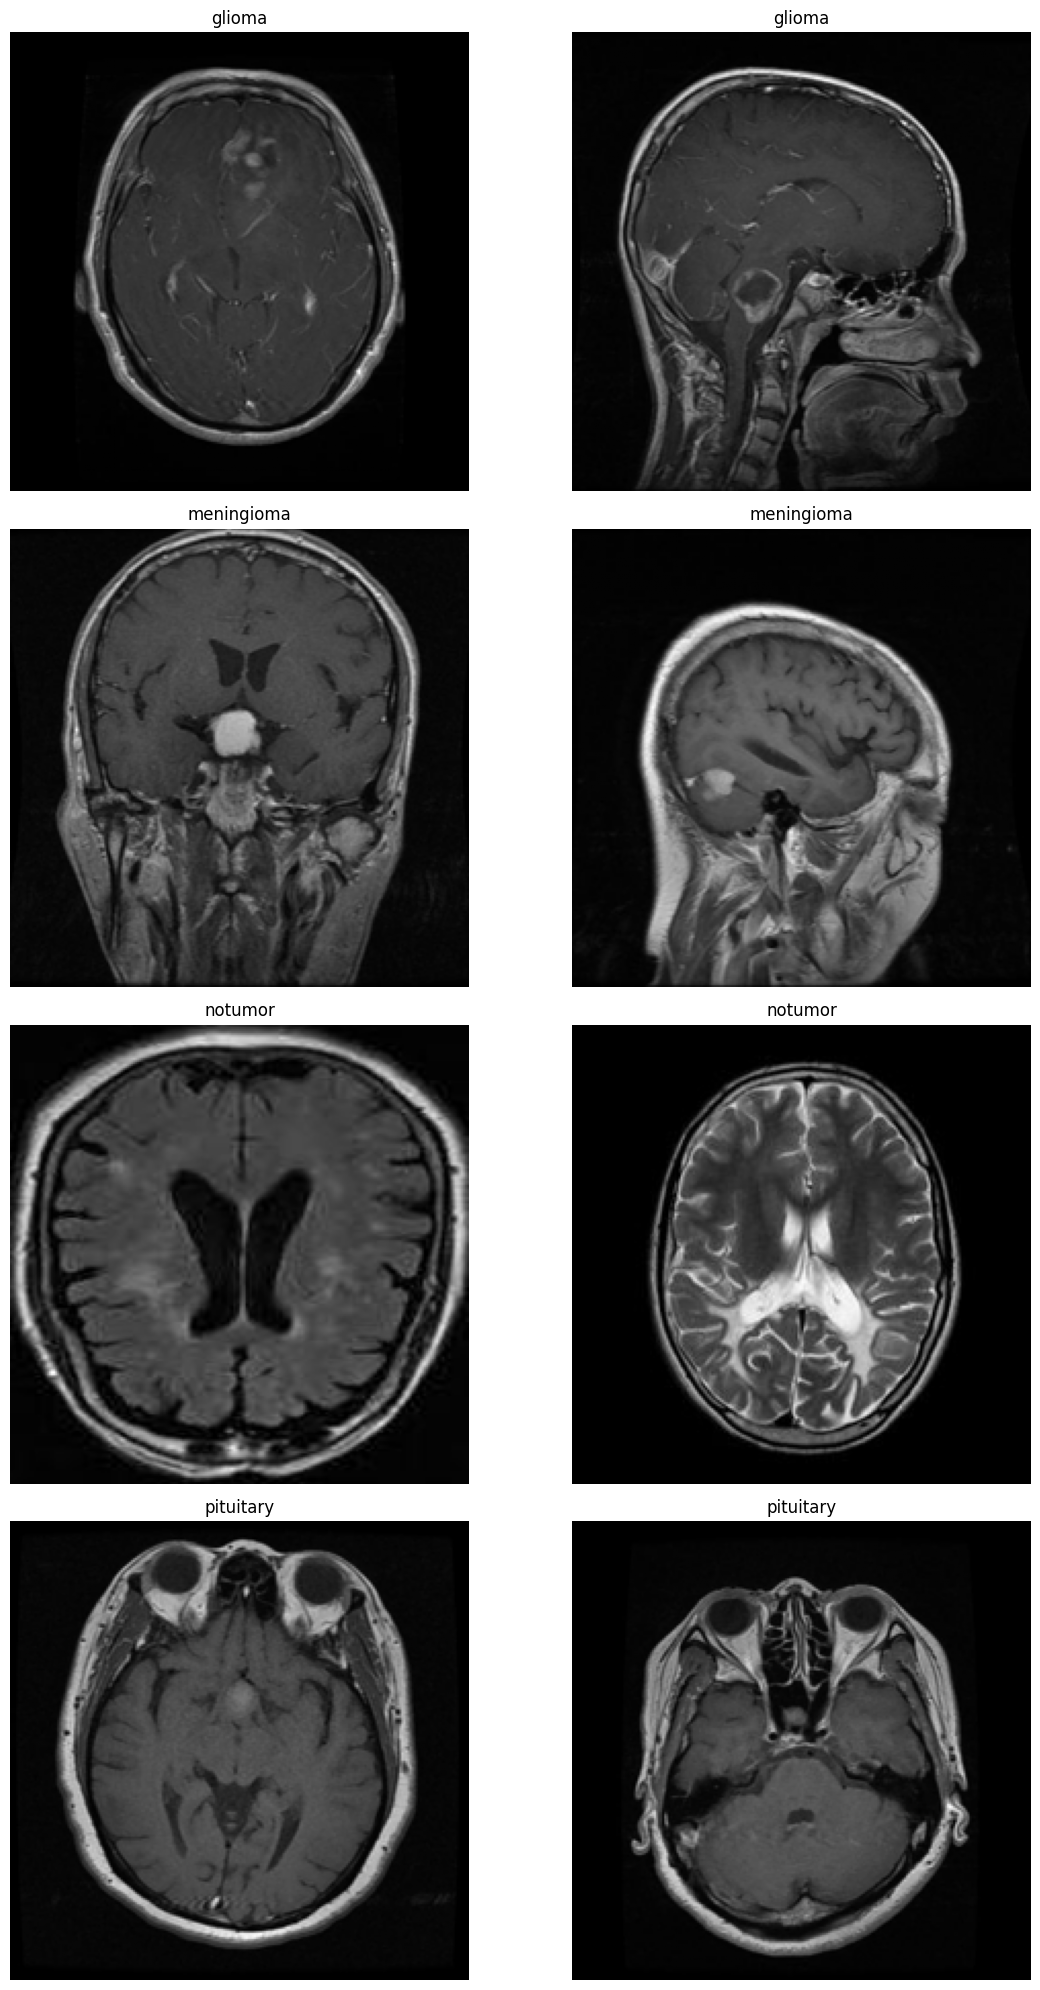

<Figure size 1500x1000 with 0 Axes>

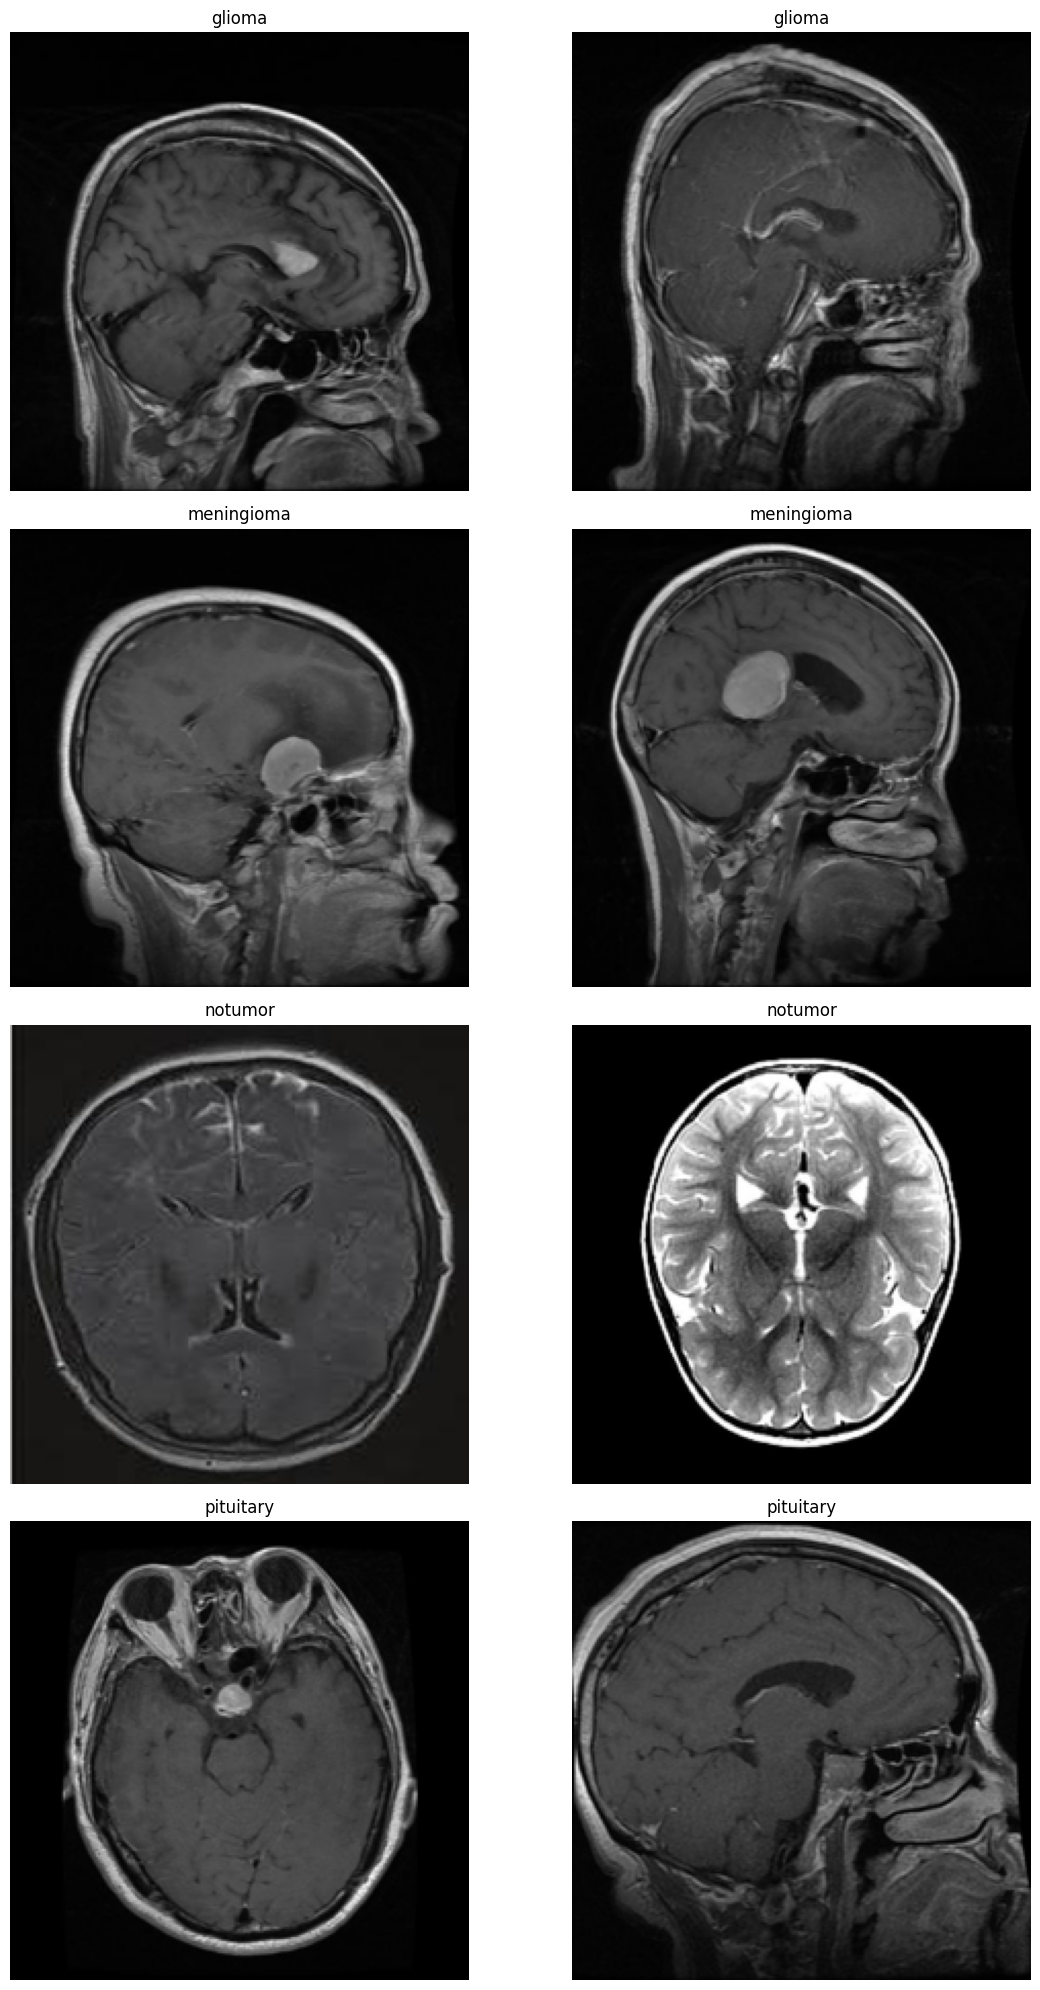

In [5]:
display_random_images(TRAIN_PATH)
display_random_images(TEST_PATH)

In [6]:
def analisar_distribuicao_classes(dataset_path: str, label_map: dict):
    """
    Args:
        dataset_path (str): Caminho para o diretório do dataset (ex: TRAIN_PATH).
        label_map (dict): Dicionário mapeando nomes de classe para inteiros (ex: LABEL_MAP).
    """
    dataset_name = os.path.basename(dataset_path)
    print(f"--- Análise de Distribuição: Conjunto '{dataset_name}' ---")

    counts = {}
    for class_name in label_map.keys():
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')) and not f.startswith('.')]
            counts[class_name] = len(image_files)
        else:
            counts[class_name] = 0
            print(f"Aviso: Diretório da classe '{class_name}' não encontrado em '{dataset_path}'")

    total_images = sum(counts.values())
    class_names = list(counts.keys())
    class_counts = list(counts.values())

    print("Resumo da Distribuição:")
    if total_images == 0:
        print("Nenhuma imagem encontrada.")
        return

    for name, count in counts.items():
        percentage = (count / total_images) * 100
        print(f"- {name.capitalize():<12} {count:>5} imagens ({percentage:.1f}%)")
    print(f"Total de imagens: {total_images}\n")

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']
    bars = ax.bar(class_names, class_counts, color=colors[:len(class_names)])

    ax.set_title(f"Distribuição de Classes no Conjunto '{dataset_name}'", fontsize=15, fontweight='bold')
    ax.set_xlabel("Classes", fontsize=12)
    ax.set_ylabel("Número de Imagens", fontsize=12)
    ax.set_xticklabels([name.capitalize() for name in class_names], ha="right")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_images) * 100
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black', bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.2'))

    plt.tight_layout()
    plt.show()

--- Análise de Distribuição: Conjunto 'Training' ---
Resumo da Distribuição:
- Notumor       1595 imagens (27.9%)
- Glioma        1321 imagens (23.1%)
- Meningioma    1339 imagens (23.4%)
- Pituitary     1457 imagens (25.5%)
Total de imagens: 5712



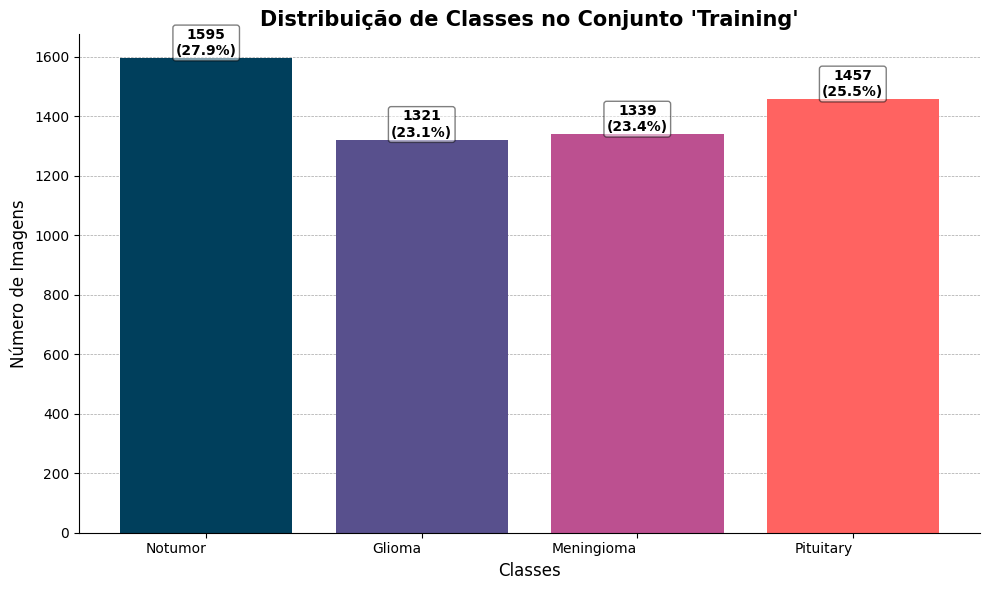

In [7]:
analisar_distribuicao_classes(dataset_path=TRAIN_PATH, label_map=LABEL_MAP)

--- Análise de Distribuição: Conjunto 'Testing' ---
Resumo da Distribuição:
- Notumor        405 imagens (30.9%)
- Glioma         300 imagens (22.9%)
- Meningioma     306 imagens (23.3%)
- Pituitary      300 imagens (22.9%)
Total de imagens: 1311



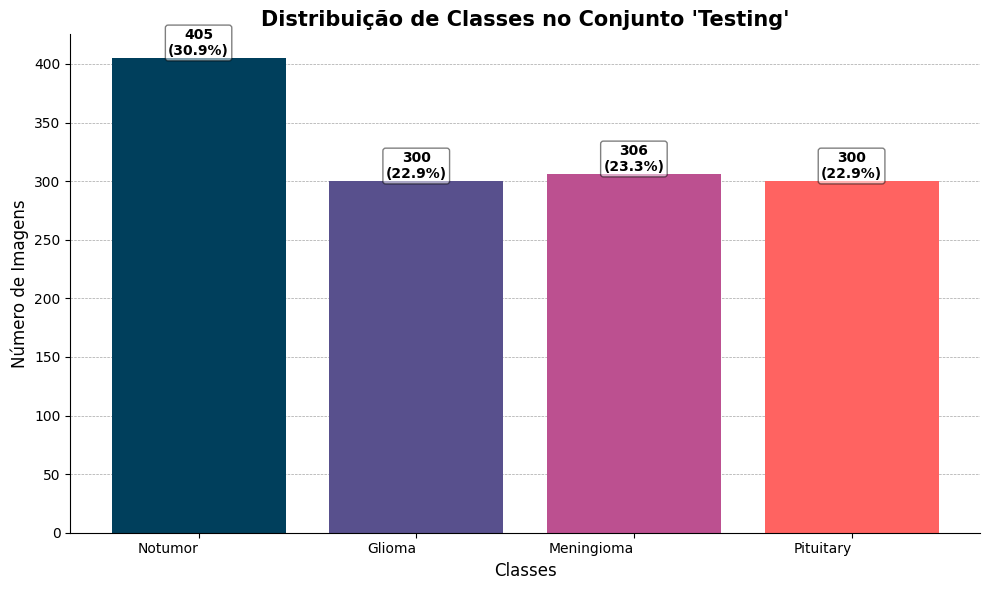

In [8]:
analisar_distribuicao_classes(dataset_path=TEST_PATH, label_map=LABEL_MAP)

<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Pre-processamento das imagens</h2>
</div>

In [9]:
def criar_dataframe_de_imagens(dataset_path: str, label_map: dict) -> pd.DataFrame:
    """
    Args:
        dataset_path (str): O caminho para o diretório do dataset (ex: TRAIN_PATH).
        label_map (dict): O dicionário que mapeia nomes de classe para rótulos inteiros.

    Returns:
        pd.DataFrame: Um DataFrame com as colunas ['caminho_arquivo', 'rotulo'].
    """
    dados_para_df = []
    for class_name, numeric_label in label_map.items():
        class_path = os.path.join(dataset_path, class_name)

        if not os.path.isdir(class_path):
            print(f"Aviso: Diretório da classe '{class_name}' não encontrado em '{dataset_path}'. Pulando.")
            continue

        for file_name in os.listdir(class_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')) and not file_name.startswith('.'):
                file_path = os.path.join(class_path, file_name)
                dados_para_df.append([file_path, numeric_label])

    if not dados_para_df:
        print(f"Aviso: Nenhum arquivo de imagem encontrado em {dataset_path}. Retornando DataFrame vazio.")
        return pd.DataFrame([], columns=['caminho_arquivo', 'rotulo'])

    return pd.DataFrame(dados_para_df, columns=['caminho_arquivo', 'rotulo'])

In [10]:
print("Criando DataFrame de Treinamento...")
train_df = criar_dataframe_de_imagens(dataset_path=TRAIN_PATH, label_map=LABEL_MAP)

print("Criando DataFrame de Teste...")
initial_test_df = criar_dataframe_de_imagens(dataset_path=TEST_PATH, label_map=LABEL_MAP)

Criando DataFrame de Treinamento...
Criando DataFrame de Teste...


In [11]:
print("\n--- Informações do DataFrame de Treino ---")
print(f"Total de amostras: {len(train_df)}")
train_df.info()


print("\n--- Informações do DataFrame de Teste ---")
print(f"Total de amostras: {len(initial_test_df)}")
initial_test_df.info()


--- Informações do DataFrame de Treino ---
Total de amostras: 5712
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   caminho_arquivo  5712 non-null   object
 1   rotulo           5712 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.4+ KB

--- Informações do DataFrame de Teste ---
Total de amostras: 1311
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   caminho_arquivo  1311 non-null   object
 1   rotulo           1311 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.6+ KB


<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Pre-processamento e particionamento</h2>
</div>

In [12]:
class TumorDataset(Dataset):
    """
    Classe de Dataset customizada para carregar as imagens de tumores cerebrais.
    Recebe um DataFrame e aplica as transformações necessárias.
    """
    def __init__(self, dataframe: pd.DataFrame, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataframe)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img_path = self.dataframe.loc[idx, 'caminho_arquivo']
        label = self.dataframe.loc[idx, 'rotulo']

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transformações para o conjunto de treino (com Data Augmentation)
TRAIN_TRANSFORMS = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),

    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Transformações para os conjuntos de validação e teste (sem Augmentation)
# Apenas redimensiona, converte para tensor e normaliza.
VAL_TEST_TRANSFORMS = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [14]:
val_df, test_df = train_test_split(
    initial_test_df,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=initial_test_df['rotulo']
)

In [15]:
# Resetando indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Tamanho final dos conjuntos:")
print(f"- Treino:    {len(train_df):>5} amostras")
print(f"- Validação: {len(val_df):>5} amostras")
print(f"- Teste:     {len(test_df):>5} amostras\n")


Tamanho final dos conjuntos:
- Treino:     5712 amostras
- Validação:   655 amostras
- Teste:       656 amostras



In [ ]:
# Instanciando a classe Dataset
train_dataset = TumorDataset(train_df, transform=TRAIN_TRANSFORMS)
val_dataset = TumorDataset(val_df, transform=VAL_TEST_TRANSFORMS)
test_dataset = TumorDataset(test_df, transform=VAL_TEST_TRANSFORMS)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Cria os DataLoaders para carregar os dados em lotes (sem multiprocessing para evitar problemas de compatibilidade,
# se for linux pode descomentar o código acima com num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


print(f"- Lotes de Treino:    {len(train_loader)} batches de tamanho {BATCH_SIZE}")
print(f"- Lotes de Validação: {len(val_loader)} batches de tamanho {BATCH_SIZE}")
print(f"- Lotes de Teste:     {len(test_loader)} batches de tamanho {BATCH_SIZE}")

- Lotes de Treino:    179 batches de tamanho 32
- Lotes de Validação: 21 batches de tamanho 32
- Lotes de Teste:     21 batches de tamanho 32


<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Criação do Modelo</h2>
</div>

In [17]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes: int = 4):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [1]:
NUM_EPOCHS = 60
LEARNING_RATE = 0.0007
PATIENCE = 10
MODEL_SAVE_NAME = "CNN_de_tumores_cerebrais"

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, model_name):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(DEVICE)

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%")

        if avg_val_loss < best_val_loss:
            print(f"Val Loss melhorou ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Salvando modelo...")
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Sem melhoria por {patience} épocas. Early stopping ativado.")
                break

    return history

In [20]:
def plot_history(history, model_name=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Histórico de Treinamento - {model_name}', fontsize=16)

    ax1.plot(history['train_loss'], label='Perda de Treino')
    ax1.plot(history['val_loss'], label='Perda de Validação')
    ax1.set_title("Curva de Perda")
    ax1.set_xlabel("Épocas")
    ax1.set_ylabel("Perda (Loss)")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Acurácia de Treino')
    ax2.plot(history['val_acc'], label='Acurácia de Validação')
    ax2.set_title("Curva de Acurácia")
    ax2.set_xlabel("Épocas")
    ax2.set_ylabel("Acurácia (%)")
    ax2.legend()
    ax2.grid(True)

    plt.show()

In [21]:
def test_model(model, test_loader, class_names):
    model.to(DEVICE)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Avaliando no conjunto de teste"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n" + "="*50)
    print("Relatório de Classificação Final")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão Final')
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.show()


<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Instanciação e treinamento</h2>
</div>

In [22]:
# Instanciação
model = BrainTumorCNN(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [23]:
# Treinamento do modelo
history = train_model(model, train_loader, val_loader, criterion, optimizer,
                      num_epochs=NUM_EPOCHS, patience=PATIENCE, model_name=MODEL_SAVE_NAME)

Epoch [1/60] | Train Loss: 0.8014, Acc: 67.19% | Val Loss: 0.9201, Acc: 67.02%
Val Loss melhorou (inf -> 0.9201). Salvando modelo...


Epoch [2/60] | Train Loss: 0.5908, Acc: 77.10% | Val Loss: 1.9422, Acc: 50.38%


Epoch [3/60] | Train Loss: 0.4878, Acc: 81.20% | Val Loss: 1.8423, Acc: 52.98%


Epoch [4/60] | Train Loss: 0.4310, Acc: 83.98% | Val Loss: 0.4465, Acc: 81.98%
Val Loss melhorou (0.9201 -> 0.4465). Salvando modelo...


Epoch [5/60] | Train Loss: 0.4134, Acc: 84.96% | Val Loss: 0.6227, Acc: 76.79%


Epoch [6/60] | Train Loss: 0.3904, Acc: 85.45% | Val Loss: 0.4795, Acc: 81.98%


Epoch [7/60] | Train Loss: 0.3596, Acc: 86.34% | Val Loss: 0.5293, Acc: 80.92%


Epoch [8/60] | Train Loss: 0.3460, Acc: 87.61% | Val Loss: 1.5440, Acc: 63.05%


Epoch [9/60] | Train Loss: 0.3345, Acc: 87.62% | Val Loss: 0.8778, Acc: 72.06%


Epoch [10/60] | Train Loss: 0.3183, Acc: 88.43% | Val Loss: 0.4555, Acc: 84.43%


Epoch [11/60] | Train Loss: 0.2983, Acc: 89.15% | Val Loss: 0.4949, Acc: 80.46%


Epoch [12/60] | Train Loss: 0.3011, Acc: 88.88% | Val Loss: 1.2276, Acc: 65.50%


Epoch [13/60] | Train Loss: 0.2998, Acc: 89.16% | Val Loss: 0.4648, Acc: 84.58%


Epoch [14/60] | Train Loss: 0.2791, Acc: 90.13% | Val Loss: 0.2864, Acc: 90.08%
Val Loss melhorou (0.4465 -> 0.2864). Salvando modelo...


Epoch [15/60] | Train Loss: 0.2796, Acc: 89.86% | Val Loss: 0.9331, Acc: 74.20%


Epoch [16/60] | Train Loss: 0.2693, Acc: 90.32% | Val Loss: 0.6608, Acc: 80.00%


Epoch [17/60] | Train Loss: 0.2509, Acc: 90.72% | Val Loss: 0.3041, Acc: 87.94%


Epoch [18/60] | Train Loss: 0.2350, Acc: 91.35% | Val Loss: 0.2778, Acc: 90.08%
Val Loss melhorou (0.2864 -> 0.2778). Salvando modelo...


Epoch [19/60] | Train Loss: 0.2333, Acc: 91.28% | Val Loss: 0.6247, Acc: 81.68%


Epoch [20/60] | Train Loss: 0.2327, Acc: 91.61% | Val Loss: 1.5822, Acc: 57.25%


Epoch [21/60] | Train Loss: 0.2067, Acc: 92.65% | Val Loss: 0.3520, Acc: 86.87%


Epoch [22/60] | Train Loss: 0.1905, Acc: 93.28% | Val Loss: 0.4229, Acc: 86.87%


Epoch [23/60] | Train Loss: 0.2070, Acc: 92.38% | Val Loss: 0.4123, Acc: 85.80%


Epoch [24/60] | Train Loss: 0.1996, Acc: 92.94% | Val Loss: 0.4669, Acc: 86.11%


Epoch [25/60] | Train Loss: 0.1798, Acc: 93.68% | Val Loss: 0.2926, Acc: 90.08%


Epoch [26/60] | Train Loss: 0.1779, Acc: 93.91% | Val Loss: 0.7545, Acc: 73.74%


Epoch [27/60] | Train Loss: 0.1713, Acc: 93.93% | Val Loss: 0.3519, Acc: 86.41%


Epoch [28/60] | Train Loss: 0.1689, Acc: 93.94% | Val Loss: 0.1503, Acc: 95.11%
Val Loss melhorou (0.2778 -> 0.1503). Salvando modelo...


Epoch [29/60] | Train Loss: 0.1711, Acc: 94.14% | Val Loss: 0.2724, Acc: 90.84%


Epoch [30/60] | Train Loss: 0.1628, Acc: 93.84% | Val Loss: 0.3516, Acc: 87.94%


Epoch [31/60] | Train Loss: 0.1458, Acc: 94.99% | Val Loss: 0.6158, Acc: 83.51%


Epoch [32/60] | Train Loss: 0.1487, Acc: 94.63% | Val Loss: 0.3424, Acc: 89.47%


Epoch [33/60] | Train Loss: 0.1572, Acc: 94.87% | Val Loss: 0.1397, Acc: 95.73%
Val Loss melhorou (0.1503 -> 0.1397). Salvando modelo...


Epoch [34/60] | Train Loss: 0.1361, Acc: 95.27% | Val Loss: 0.1666, Acc: 93.89%


Epoch [35/60] | Train Loss: 0.1441, Acc: 94.70% | Val Loss: 0.2943, Acc: 90.08%


Epoch [36/60] | Train Loss: 0.1266, Acc: 95.41% | Val Loss: 0.1500, Acc: 94.81%


Epoch [37/60] | Train Loss: 0.1212, Acc: 95.78% | Val Loss: 0.1919, Acc: 94.96%


Epoch [38/60] | Train Loss: 0.1228, Acc: 95.73% | Val Loss: 0.3940, Acc: 87.18%


Epoch [39/60] | Train Loss: 0.1217, Acc: 95.78% | Val Loss: 0.5059, Acc: 85.65%


Epoch [40/60] | Train Loss: 0.1223, Acc: 95.69% | Val Loss: 0.1347, Acc: 96.49%
Val Loss melhorou (0.1397 -> 0.1347). Salvando modelo...


Epoch [41/60] | Train Loss: 0.1016, Acc: 96.52% | Val Loss: 0.2231, Acc: 92.82%


Epoch [42/60] | Train Loss: 0.1081, Acc: 96.34% | Val Loss: 0.1529, Acc: 95.88%


Epoch [43/60] | Train Loss: 0.1287, Acc: 95.41% | Val Loss: 0.2143, Acc: 92.06%


Epoch [44/60] | Train Loss: 0.1187, Acc: 95.87% | Val Loss: 0.2503, Acc: 91.30%


Epoch [45/60] | Train Loss: 0.1039, Acc: 96.22% | Val Loss: 0.1957, Acc: 93.44%


Epoch [46/60] | Train Loss: 0.0940, Acc: 96.90% | Val Loss: 0.1017, Acc: 96.64%
Val Loss melhorou (0.1347 -> 0.1017). Salvando modelo...


Epoch [47/60] | Train Loss: 0.1010, Acc: 96.48% | Val Loss: 0.1562, Acc: 95.27%


Epoch [48/60] | Train Loss: 0.1031, Acc: 96.36% | Val Loss: 0.2768, Acc: 90.84%


Epoch [49/60] | Train Loss: 0.0846, Acc: 97.09% | Val Loss: 0.1852, Acc: 94.05%


Epoch [50/60] | Train Loss: 0.1024, Acc: 96.41% | Val Loss: 0.1160, Acc: 94.96%


Epoch [51/60] | Train Loss: 0.0798, Acc: 97.11% | Val Loss: 0.2068, Acc: 92.52%


Epoch [52/60] | Train Loss: 0.0759, Acc: 97.32% | Val Loss: 0.2337, Acc: 92.52%


Epoch [53/60] | Train Loss: 0.0972, Acc: 96.67% | Val Loss: 0.1575, Acc: 95.42%


Epoch [54/60] | Train Loss: 0.0773, Acc: 97.37% | Val Loss: 0.1302, Acc: 96.18%


Epoch [55/60] | Train Loss: 0.0917, Acc: 97.16% | Val Loss: 0.3946, Acc: 86.87%


Epoch [56/60] | Train Loss: 0.0842, Acc: 96.99% | Val Loss: 0.1255, Acc: 94.81%
Sem melhoria por 10 épocas. Early stopping ativado.


<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Testando o modelo treinado</h2>
</div>

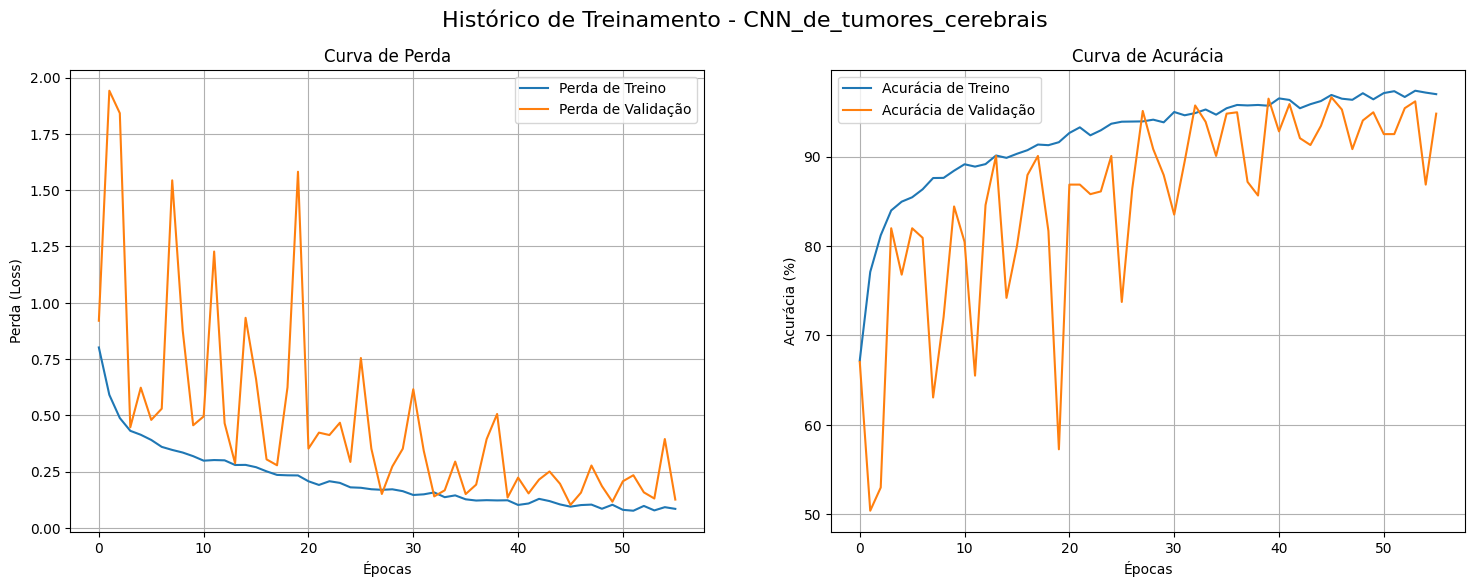


Carregando o melhor modelo salvo para avaliação final no conjunto de teste...


Avaliando no conjunto de teste: 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]


Relatório de Classificação Final
              precision    recall  f1-score   support

     notumor       1.00      0.94      0.97       203
      glioma       0.98      0.99      0.98       150
  meningioma       0.91      0.97      0.94       153
   pituitary       0.99      0.99      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



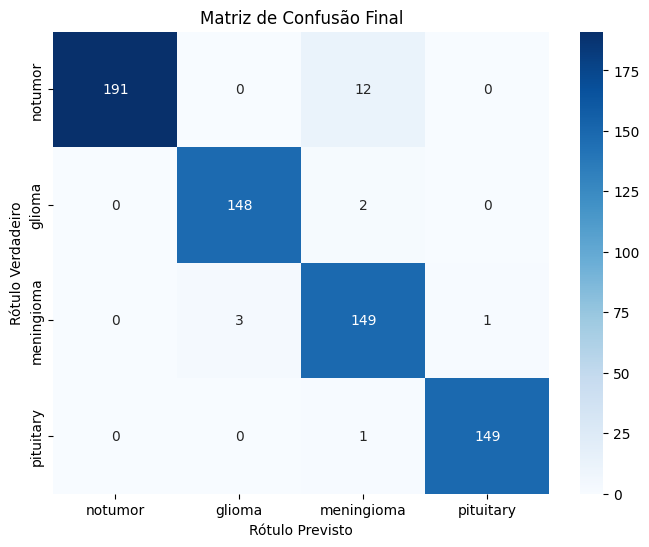

In [26]:
plot_history(history, model_name=MODEL_SAVE_NAME)

print("\nCarregando o melhor modelo salvo para avaliação final no conjunto de teste...")
final_model = BrainTumorCNN(num_classes=NUM_CLASSES)
final_model.load_state_dict(torch.load(f'best_{MODEL_SAVE_NAME}.pth'))

class_names = list(LABEL_MAP_INV.values())
test_model(final_model, test_loader, class_names=class_names)

<div style="background-color:#f0f0f0; padding:15px; border-radius:5px; color:black;">
  <h3 style="text-align:center;">Salvando histórico em JSON / PKL</h2>
</div>

In [ ]:
import pickle

with open(f'history_{MODEL_SAVE_NAME}.pkl', 'wb') as f:
    pickle.dump(history, f)

print(f"Histórico de treinamento salvo em 'history_{MODEL_SAVE_NAME}.pkl'")

# import pickle

# with open(f'history_{MODEL_SAVE_NAME}.pkl', 'rb') as f:
#     loaded_history = pickle.load(f)

# Agora você pode usar o loaded_history para plotar os gráficos
# plot_history(loaded_history, model_name=MODEL_SAVE_NAME)

Histórico de treinamento salvo em 'history_CNN_de_tumores_cerebrais.pkl'


In [ ]:
import json

with open(f'history_{MODEL_SAVE_NAME}.json', 'w') as f:
    json.dump(history, f, indent=4)

print(f"Histórico de treinamento salvo em 'history_{MODEL_SAVE_NAME}.json'")

# import json

# with open(f'history_{MODEL_SAVE_NAME}.json', 'r') as f:
#     loaded_history = json.load(f)

# plot_history(loaded_history, model_name=MODEL_SAVE_NAME)

Histórico de treinamento salvo em 'history_CNN_de_tumores_cerebrais.json'


In [3]:
import json

with open(f'history_{MODEL_SAVE_NAME}.json', 'r') as f:
    loaded_history = json.load(f)

In [4]:
def plot_loss_history(history, model_name=""):
    """
    Plota a curva de perda (loss) do treinamento e validação.
    """
    plt.figure(figsize=(10, 6))

    plt.plot(history['train_loss'], label='Perda de Treino', color='#003f5c')
    plt.plot(history['val_loss'], label='Perda de Validação', color='#ff6361')

    plt.title(f'Curva de Perda - {model_name}', fontsize=16)
    plt.xlabel("Épocas", fontsize=12)
    plt.ylabel("Perda (Loss)", fontsize=12)

    plt.legend()
    plt.grid(True)

    plt.show()

def plot_accuracy_history(history, model_name=""):
    """
    Plota a curva de acurácia do treinamento e validação.
    """
    plt.figure(figsize=(10, 6))

    plt.plot(history['train_acc'], label='Acurácia de Treino', color='#58508d')
    plt.plot(history['val_acc'], label='Acurácia de Validação', color='#ffa600')

    plt.title(f'Curva de Acurácia - {model_name}', fontsize=16)
    plt.xlabel("Épocas", fontsize=12)
    plt.ylabel("Acurácia (%)", fontsize=12)

    plt.legend()
    plt.grid(True)

    plt.show()

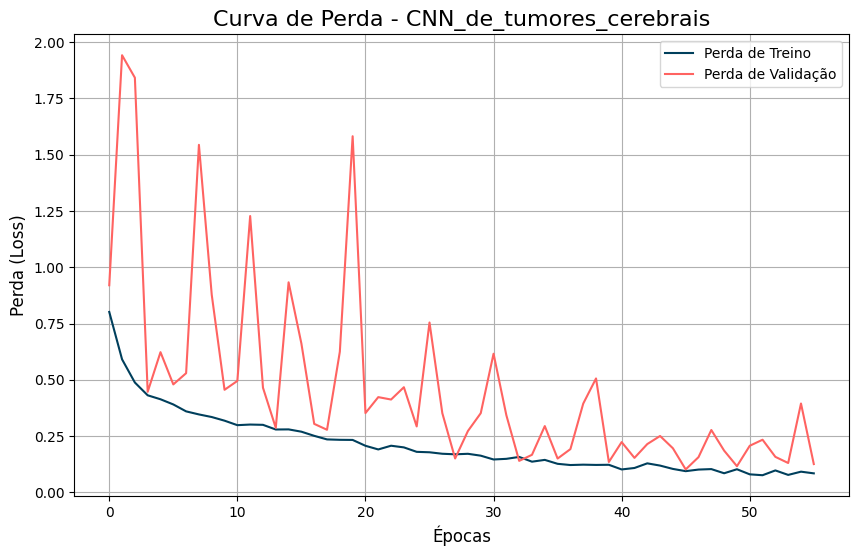

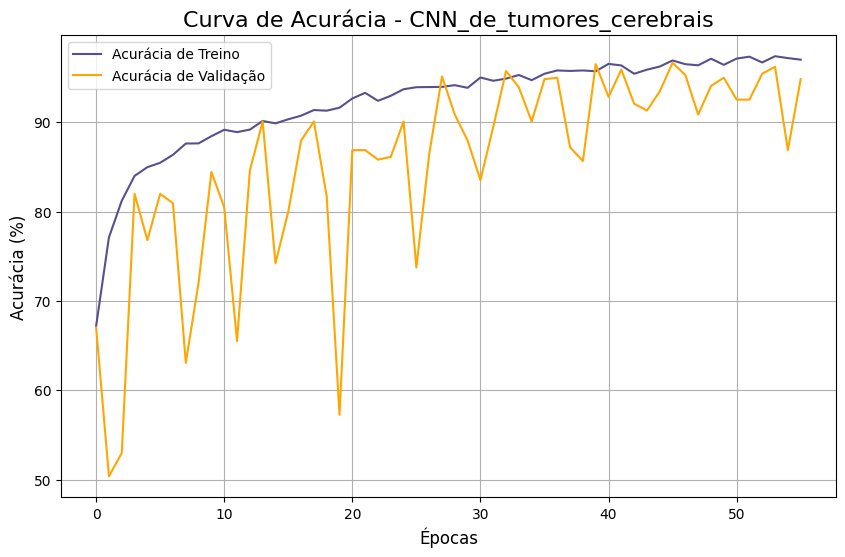

In [7]:
plot_loss_history(loaded_history, model_name=MODEL_SAVE_NAME)
plot_accuracy_history(loaded_history, model_name=MODEL_SAVE_NAME)